<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_07/blob/main/goit_python_ds_hw_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 7. Рекомендаційні системи.

*З циклу [домашніх завдань Python Data Science](https://github.com/lexxai/goit_python_data_sciense_homework).*

# Домашнє завдання

## LOAD DATASET

In [90]:
!pip install scikit-surprise

In [91]:
from surprise import accuracy, Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
import pandas as pd
import numpy as np
from pathlib import Path

In [92]:
laod_mode = "load_from_df"

In [194]:
if laod_mode == "load_builtin":
  # Load the movielens-100k dataset (download it if needed).
  data = Dataset.load_builtin('ml-100k', prompt=False)

In [94]:
if laod_mode == "load_builtin":
  !ls -1  /root/.surprise_data/ml-100k/ml-100k/u* | sed  's/\/root\/\.surprise_data\/ml-100k\/ml-100k\///g' | sort

In [95]:
if laod_mode == "load_builtin":
  base_path = Path("/root/.surprise_data/ml-100k/ml-100k")
  filelist =  list(map(lambda x: x.name, sorted(base_path.glob("u*"))))
  types = {
      "test": "Test_files",
      "base": "Train_files"
  }
  for f, d in types.items():
    print(f"\n{d}:")
    print(list(filter(lambda x : x.endswith(f".{f}") ,filelist)))

In [96]:
  latest_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
  latest_zip_file = Path("ml-latest-small.zip")
  if not latest_zip_file.exists():
    !wget $latest_url
    !unzip $latest_zip_file
  base_path = Path("/content/ml-latest-small/")
  rating_csv = base_path.joinpath("ratings.csv")
  tags_csv = base_path.joinpath("tags.csv")
  movies_csv = base_path.joinpath("movies.csv")

In [97]:
if laod_mode == "load_from_file":
  reader = Reader(line_format=u'user item rating timestamp', sep=',', rating_scale=(1, 5), skip_lines=1)
  data = Dataset.load_from_file(rating_csv, reader=reader)

In [98]:
if laod_mode == "load_from_df":
  df = pd.read_csv(rating_csv)

  # A reader is still needed but only the rating_scale param is requiered.
  reader = Reader(rating_scale=(1, 5))

  # The columns must correspond to user id, item id and ratings (in that order).
  data = Dataset.load_from_df(df[["userId", "movieId",  "rating"]], reader)

In [99]:
type(data)

surprise.dataset.DatasetAutoFolds

### Аналіз записів

Неважлива інофромаційна частина для пошуку реальних значень з датасету: uid, iid, ur. А також для уявлення змісту даних датасету.

In [100]:
from datetime import date

dater = None

# Access dataset attributes
raw_ratings = data.raw_ratings
print("Number of ratings:", len(raw_ratings))

# Print a sample of raw ratings
print("\nTop 5 samples of raw ratings:")
for rating in raw_ratings[:5]:
  uid, iid, ur, timestamp = rating
  if timestamp:
    dater = date.fromtimestamp(int(timestamp))
  print(f"UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")

search_uid = uid
count_uid = 5
print(f"\nTop {count_uid} ratings of user: {search_uid}")

for rating in raw_ratings:
  uid, iid, ur, timestamp = rating
  if uid == search_uid:
    if timestamp:
      dater = date.fromtimestamp(int(timestamp))
    count_uid -= 1;
    print(f"UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")
    if count_uid <= 0:
      break

search_iid = iid
count_iid = 5
print(f"\nTop {count_iid} ratings of item: {search_iid}")

for rating in raw_ratings:
  uid, iid, ur, timestamp = rating
  if iid == search_iid:
    if timestamp:
      dater = date.fromtimestamp(int(timestamp))
    count_iid -= 1;
    print(f"UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")
    if count_iid <= 0:
      break

Number of ratings: 100836

Top 5 samples of raw ratings:
UserID:     1, ItemID:     1, UserRateForItem:   4.0, date: None
UserID:     1, ItemID:     3, UserRateForItem:   4.0, date: None
UserID:     1, ItemID:     6, UserRateForItem:   4.0, date: None
UserID:     1, ItemID:    47, UserRateForItem:   5.0, date: None
UserID:     1, ItemID:    50, UserRateForItem:   5.0, date: None

Top 5 ratings of user: 1
UserID:     1, ItemID:     1, UserRateForItem:   4.0, date: None
UserID:     1, ItemID:     3, UserRateForItem:   4.0, date: None
UserID:     1, ItemID:     6, UserRateForItem:   4.0, date: None
UserID:     1, ItemID:    47, UserRateForItem:   5.0, date: None
UserID:     1, ItemID:    50, UserRateForItem:   5.0, date: None

Top 5 ratings of item: 50
UserID:     1, ItemID:    50, UserRateForItem:   5.0, date: None
UserID:     5, ItemID:    50, UserRateForItem:   4.0, date: None
UserID:     6, ItemID:    50, UserRateForItem:   1.0, date: None
UserID:     7, ItemID:    50, UserRateForItem

Використовуєтьс прямий відгук (Explicit feedback) - це оцінка, яку користувач поставив, щоб висловити свою задоволеність товаром.

Для оцінки що базується на спільній інформації про користувачів  та їхню взаємодію з об'єктами (Collaborative Filtering) вибранно модель матричної факторизації (Matrix Factorization).

In [101]:
# uid = 6
# iid = 258
# ur = 2.0
# dater = "1997-12-28"

Ми використовуємо об'єкт ***DatasetAutoFolds*** у Surprise, це означає, що ми працюємо з набором даних, який вже було розбито на файли (folds) для перехресної перевірки.



Мета цього методу - охопити загальний випадок використання, коли набір даних вже розбито на попередньо визначені складові, наприклад, набір даних movielens-100k ('ml-100k'), який визначає файли u1.base, u1.test, u2.base, u2.test і т.д... Його також можна використовувати, коли ми не хочемо виконувати перехресну перевірку, але все одно хочемо вказати наші навчальні та тестові дані (що в будь-якому випадку зводиться до 1-кратної перехресної перевірки).

## Mоделі матричної факторизації

### Algorithm SVD.

Метод SVD може бути адаптований до наборів даних з неявним зворотним зв'язком (implicit feedback).


- RMSE - root-mean-square error
- MAE - mean absolute error

In [102]:
SEED = 42
algo_cv = {}
algo_split = {}
# Use the SVD algorithm.
algo = SVD(random_state=SEED)

#### Прогноз

#### Full_trainset та він же і testset. Accuracy RMSE (root-mean-square error).


In [103]:
def data_full_trainset(algo, data):
  algorithm_name = algo.__class__.__name__
  print(f"Algo: {algorithm_name}, UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")

  #trainset, testset = train_test_split(data, test_size=0.25)
  trainset = data.build_full_trainset()

  print("Number of train ratings:", len(list(trainset.all_ratings())))
  algo.fit(trainset)
  pred = algo.predict(uid, iid, r_ui=ur, verbose=True)

  testset = trainset.build_testset()
  print("Number of test ratings:", len(testset))

  predictions = algo.test(testset)
  # RMSE має бути низьким, оскільки ми є упередженими
  accuracy.rmse(predictions, verbose=True)  # ~ 0.68 (що є низьким показником)

In [104]:
data_full_trainset(algo, data)

Algo: SVD, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 100836
user: 8          item: 50         r_ui = 5.00   est = 4.39   {'was_impossible': False}
Number of test ratings: 100836
RMSE: 0.6390


#### Train_test_split 25%. Accuracy RMSE (root-mean-square error).


In [105]:
def data_train_test_split(algo, data, test_size=0.25):
  algorithm_name = algo.__class__.__name__
  print(f"Algo: {algorithm_name}, UserID: {uid:5}, ItemID: {iid:5}, UserRateForItem: {ur:5}, date: {dater}")
  trainset, testset = train_test_split(data, test_size=test_size)

  print("Number of train ratings:", len(list(trainset.all_ratings())))
  algo.fit(trainset)
  pred = algo.predict(uid, iid, r_ui=ur, verbose=True)

  print("Number of test ratings:", len(testset))

  predictions = algo.test(testset)
  # RMSE має бути більшим
  rmse = accuracy.rmse(predictions, verbose=True)  # ~ 0.94 (що є високим показником)
  return {algorithm_name: rmse}

In [106]:
algo_split.update(data_train_test_split(algo, data))

Algo: SVD, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 75627
user: 8          item: 50         r_ui = 5.00   est = 4.39   {'was_impossible': False}
Number of test ratings: 25209
RMSE: 0.8845


#### Cross Validate, cv = 5

In [107]:
import numpy as np

def data_cross_validate(algo, data, cv=5):
  algorithm_name = algo.__class__.__name__
  print(f"Algo: {algorithm_name}. Cross Validate: {cv}")
  # Run 5-fold cross-validation and print results.
  cv_result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=cv, verbose=True)
  mean_rmse = np.array(cv_result.get('test_rmse')).mean()
  mean_fit = np.array(cv_result.get('fit_time')).mean()
  mean_test = np.array(cv_result.get('test_time')).mean()

  print(f"{mean_rmse=}")
  return {algorithm_name: (mean_rmse, mean_fit, mean_test)}

In [108]:
algo_cv.update(data_cross_validate(algo, data))

Algo: SVD. Cross Validate: 5
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8684  0.8724  0.8792  0.8838  0.8769  0.8761  0.0053  
MAE (testset)     0.6680  0.6728  0.6746  0.6772  0.6744  0.6734  0.0030  
Fit time          1.73    2.98    3.55    3.53    4.92    3.34    1.03    
Test time         0.12    0.57    0.28    0.27    0.21    0.29    0.15    
mean_rmse=0.8761268456602316


### Algorithm SVD++ (SVDpp)

Алгоритм SVD++ можна використовувати, коли ми маємо доступ як до явного (explicit), так і до неявного (implicit) зворотного зв'язку. Це може бути дуже корисно, тому що зазвичай користувачі взаємодіють з багатьма елементами (= неявний зворотній зв'язок), але оцінюють лише невелику підмножину з них (= явний зворотній зв'язок).


In [109]:
 # surprise.prediction_algorithms.matrix_factorization.SVDpp
from surprise import SVDpp

# Use the SVDpp algorithm.
algo = SVDpp()

In [110]:
data_full_trainset(algo, data)

Algo: SVDpp, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 100836
user: 8          item: 50         r_ui = 5.00   est = 4.36   {'was_impossible': False}
Number of test ratings: 100836
RMSE: 0.6804


In [111]:
algo_split.update(data_train_test_split(algo, data))

Algo: SVDpp, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 75627
user: 8          item: 50         r_ui = 5.00   est = 4.26   {'was_impossible': False}
Number of test ratings: 25209
RMSE: 0.8550


In [112]:
algo_cv.update(data_cross_validate(algo, data))

Algo: SVDpp. Cross Validate: 5
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8606  0.8589  0.8639  0.8646  0.8568  0.8609  0.0029  
MAE (testset)     0.6604  0.6585  0.6616  0.6620  0.6592  0.6604  0.0013  
Fit time          87.49   90.68   87.69   97.83   98.22   92.38   4.75    
Test time         12.65   12.48   12.65   12.57   12.21   12.51   0.16    
mean_rmse=0.8609489445932184


### Algorithm NMF

In [113]:
# surprise.prediction_algorithms.matrix_factorization.NMF
from surprise import NMF

# Use the NMF algorithm.
algo = NMF()

In [114]:
data_full_trainset(algo, data)

Algo: NMF, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 100836
user: 8          item: 50         r_ui = 5.00   est = 4.42   {'was_impossible': False}
Number of test ratings: 100836
RMSE: 0.6408


In [115]:
algo_split.update(data_train_test_split(algo, data))

Algo: NMF, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 75627
user: 8          item: 50         r_ui = 5.00   est = 4.23   {'was_impossible': False}
Number of test ratings: 25209
RMSE: 0.9239


In [116]:
algo_cv.update(data_cross_validate(algo, data))

Algo: NMF. Cross Validate: 5
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9199  0.9248  0.9203  0.9218  0.9199  0.9214  0.0019  
MAE (testset)     0.7028  0.7072  0.7046  0.7073  0.7054  0.7055  0.0017  
Fit time          2.82    3.13    2.98    2.70    2.79    2.88    0.15    
Test time         0.11    0.35    0.13    0.24    0.12    0.19    0.09    
mean_rmse=0.9213600143709174


## Сімейство алгоритмів k-NN



Ці алгоритми безпосередньо випливають з базового методу найближчих сусідів.


### Algorithm KNNBasic.

"Сусідів" до: k=40

In [117]:
from surprise import KNNBasic

# Build an algorithm, and train it.
algo = KNNBasic()

In [118]:
data_full_trainset(algo, data)

Algo: KNNBasic, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 100836
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 8          item: 50         r_ui = 5.00   est = 4.64   {'actual_k': 40, 'was_impossible': False}
Number of test ratings: 100836
RMSE: 0.7265


In [119]:
algo_split.update(data_train_test_split(algo, data))

Algo: KNNBasic, UserID:     8, ItemID:    50, UserRateForItem:   5.0, date: None
Number of train ratings: 75627
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 8          item: 50         r_ui = 5.00   est = 4.31   {'actual_k': 40, 'was_impossible': False}
Number of test ratings: 25209
RMSE: 0.9490


In [120]:
algo_cv.update(data_cross_validate(algo, data))

Algo: KNNBasic. Cross Validate: 5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9440  0.9563  0.9512  0.9550  0.9366  0.9486  0.0074  
MAE (testset)     0.7253  0.7340  0.7280  0.7279  0.7190  0.7268  0.0048  
Fit time          0.14    0.15    0.16    0.15    0.16    0.15    0.00    
Test time         1.36    2.22    1.37    1.33    1.35    1.52    0.35    
mean_rmse=0.9486138698730862


## Результати accuracy для різних алгоритмів

In [121]:
algo_split

{'SVD': 0.8845328826142023,
 'SVDpp': 0.854963027038533,
 'NMF': 0.9238722015638993,
 'KNNBasic': 0.9490405549770013}

In [122]:
algo_split_s = dict(sorted(algo_split.items(), key=lambda x: x[1]))

In [254]:
import matplotlib.pyplot as plt

def plot_algo(input_data: dict, title_type: str = "", ylabel_type: str="RMSE", column=None):
  x = list(input_data.keys())
  if column is None:
    y = list(input_data.values())
  else:
    y = [v[column] for v in input_data.values()]

  plt.figure(figsize=(16, 5))
  max_y = y[-1]*1.02
  min_y = y[0]*.95
  plt.ylim(min_y, max_y)
  plt.title(f"Результати {title_type} для різних алгоритмів")

  cmap = plt.get_cmap('Paired')
  num_colors = len(x)
  colors_map = [cmap(i / num_colors) for i in range(num_colors)]
  custom_colors = {key: colors_map[i] for i,key in enumerate(sorted(x))}
  colors = [custom_colors.get(x_v, 'blue') for x_v in x]

  plt.bar(x, height=y, width=0.6, label=x, color=colors)
  plt.plot(x, y, "o-")
  plt.xlabel("Назва алгоритму")
  plt.ylabel(ylabel_type)
  plt.vlines(x[0], min_y, max_y, color="red", linestyle="-.", label="Best Algo, lower value")
  plt.hlines(y[0], -0.3, x[-1], color="red", linestyle="-.")
  diff_y = np.diff(y) / y[:-1] * 100
  for i, val in enumerate(y):
      text = str(round(val,4))
      if i>0:
        text += f" [{round(diff_y[i-1],1):+}%]"
      plt.text(x[i], val * 1.01, text, ha='center', bbox=dict(facecolor='white', alpha=0.95))
  plt.legend(loc="best")
  plt.show()
  print(f"Best algo: {x[0]}, with value: {y[0]:.4f}")

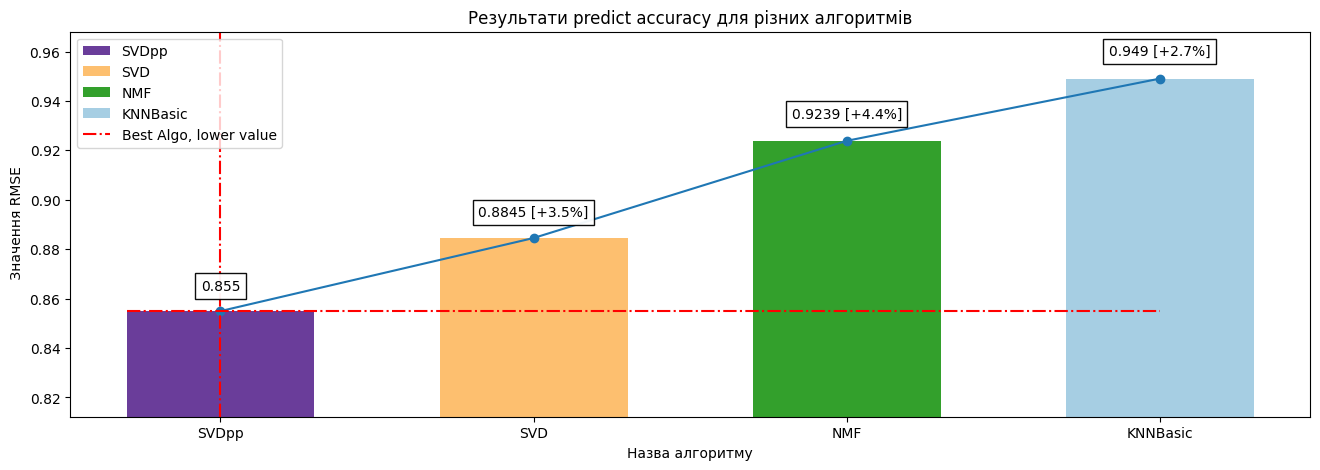

Best algo: SVDpp, with value: 0.8550


In [255]:
plot_algo(algo_split_s, "predict accuracy", " Значення RMSE")

## Результати кросвалідації для різних алгоритмів

In [125]:
algo_cv

Best algo: SVDpp, with value: 0.8550


{'SVD': (0.8761268456602316, 3.340492916107178, 0.29151358604431155),
 'SVDpp': (0.8609489445932184, 92.3836612701416, 12.512887954711914),
 'NMF': (0.9213600143709174, 2.8842977046966554, 0.1874476909637451),
 'KNNBasic': (0.9486138698730862, 0.15097012519836425, 1.524953508377075)}

['KNNBasic' 'NMF' 'SVD' 'SVDpp']
[3 2 1 0]
{'KNNBasic': (0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0), 'NMF': (0.2, 0.6274509803921569, 0.17254901960784313, 1.0), 'SVD': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883, 1.0), 'SVDpp': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0)}


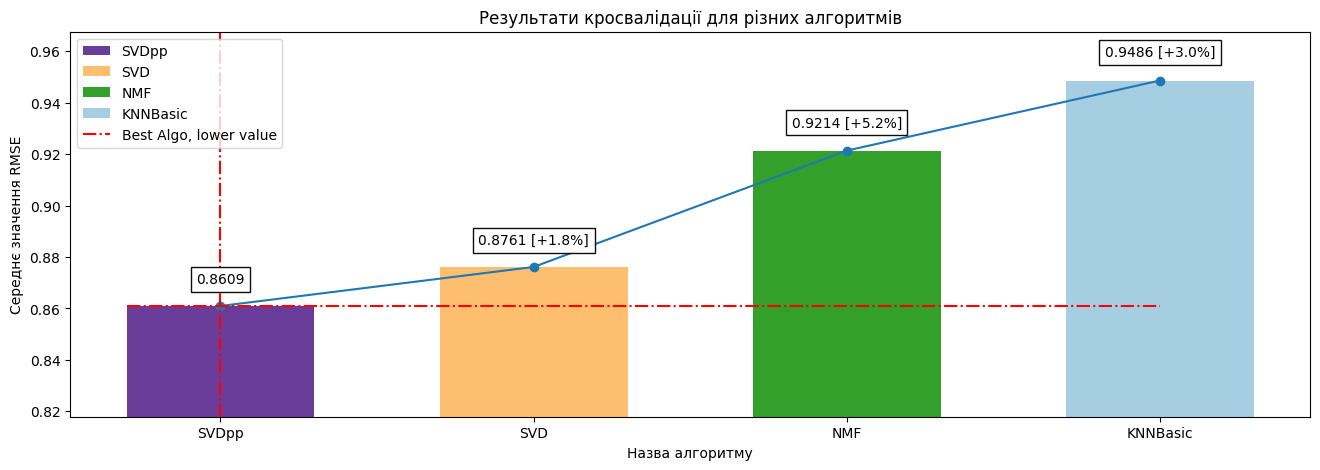

Best algo: SVDpp, with value: 0.8609


In [249]:
column = 0
algo_cv_s_rmse = dict(sorted(algo_cv.items(), key=lambda x: x[1][column]))
plot_algo(algo_cv_s_rmse, "кросвалідації", "Середнє значення RMSE", column=column)

['KNNBasic' 'NMF' 'SVD' 'SVDpp']
[0 1 2 3]
{'KNNBasic': (0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0), 'NMF': (0.2, 0.6274509803921569, 0.17254901960784313, 1.0), 'SVD': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883, 1.0), 'SVDpp': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0)}


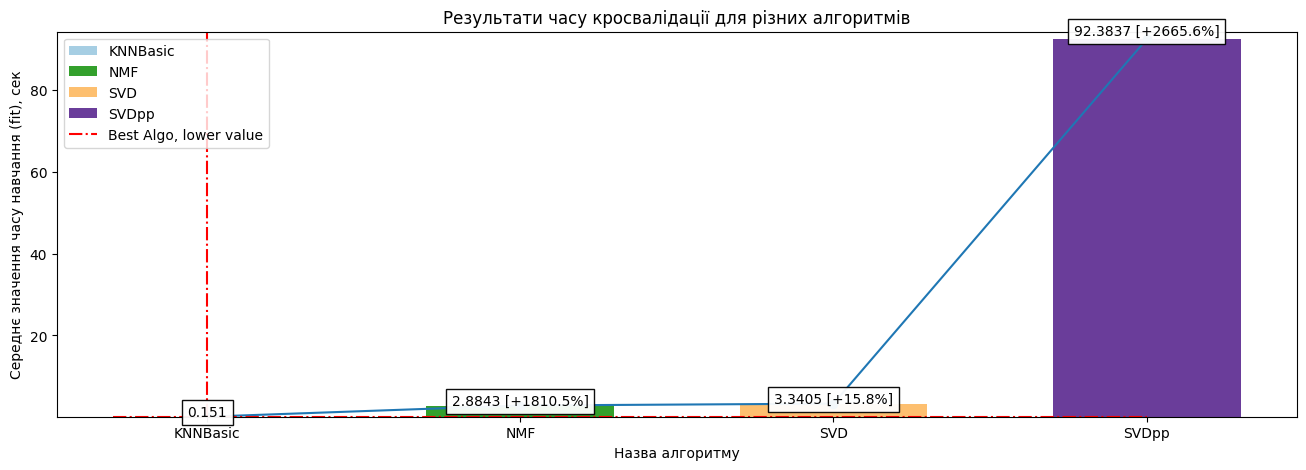

Best algo: KNNBasic, with value: 0.1510


In [250]:
column = 1
algo_cv_s_fit = dict(sorted(algo_cv.items(), key=lambda x: x[1][column]))
plot_algo(algo_cv_s_fit, "часу кросвалідації", "Середнє значення часу навчання (fit), сек", column=column)

['KNNBasic' 'NMF' 'SVD' 'SVDpp']
[2 0 1 3]
{'KNNBasic': (0.6509803921568628, 0.807843137254902, 0.8901960784313725, 1.0), 'NMF': (0.2, 0.6274509803921569, 0.17254901960784313, 1.0), 'SVD': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883, 1.0), 'SVDpp': (0.41568627450980394, 0.23921568627450981, 0.6039215686274509, 1.0)}


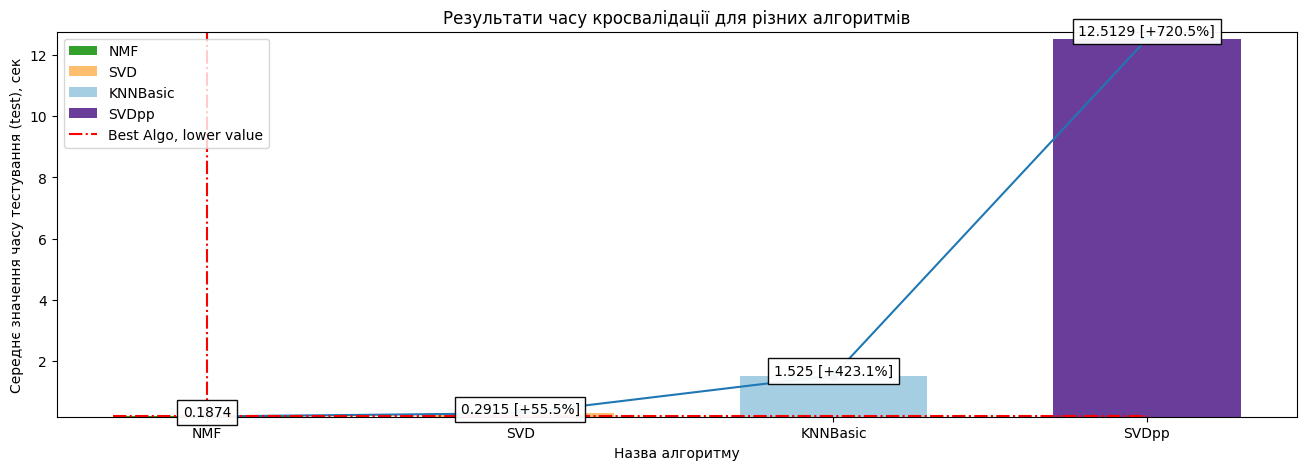

Best algo: NMF, with value: 0.1874


In [251]:
column = 2
algo_cv_s_test = dict(sorted(algo_cv.items(), key=lambda x: x[1][column]))
plot_algo(algo_cv_s_test, "часу кросвалідації", "Середнє значення часу тестування (test), сек",  column=column)

## Найкращій алгорим

- за точністю предбачення: SVD++, SVD
- за часом навчання моделі: KNNBasic, SVD
- за часом тестування моделі: NMF,SVD

Тому вибираємо для подальшіх розрахунків за критерієм точності: SVD++, але за критерієм швидкісті та точності вибриаємо: SVD.

In [129]:
best_algo = SVDpp

## Пошук оптимальних параметрів використовуючи GridSearchCV для SVD++ (SVDpp)

In [130]:
from surprise.model_selection import GridSearchCV

param_grid = {"random_state": [SEED],
              "n_epochs": [15, 20], "lr_all": [0.007], "reg_all": [0.02, 0.2]
              }
gs = GridSearchCV(best_algo, param_grid, measures=["rmse"], cv=5, n_jobs=-1)

%time gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
best_params = gs.best_params["rmse"]
print(f"{best_params=}")

CPU times: user 16 s, sys: 2.88 s, total: 18.9 s
Wall time: 23min 55s
0.8601591251668891
best_params={'random_state': 42, 'n_epochs': 15, 'lr_all': 0.007, 'reg_all': 0.02}


#### Звіт роботи GridSearchCV для всіх комбінацій параметрів

In [131]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head(10)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_random_state,param_n_epochs,param_lr_all,param_reg_all
0,0.849822,0.866591,0.861338,0.858759,0.864285,0.860159,0.005807,1,108.221180,0.793481,16.967878,0.576956,"{'random_state': 42, 'n_epochs': 15, 'lr_all':...",42,15,0.007,0.02
1,0.861668,0.879245,0.875025,0.872400,0.879619,0.873591,0.006541,4,108.487505,1.351501,16.819253,0.694223,"{'random_state': 42, 'n_epochs': 15, 'lr_all':...",42,15,0.007,0.20
2,0.851373,0.867429,0.861217,0.857870,0.863819,0.860342,0.005470,2,144.561456,0.511957,16.480368,0.626242,"{'random_state': 42, 'n_epochs': 20, 'lr_all':...",42,20,0.007,0.02
3,0.859667,0.877133,0.873002,0.870068,0.877709,0.871516,0.006552,3,144.454865,0.756842,15.305020,1.416840,"{'random_state': 42, 'n_epochs': 20, 'lr_all':...",42,20,0.007,0.20


#### навчання на full_trainset для найкращого алгоритму

In [132]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator["rmse"]

## Найкращі рекомендації для користувачів (SVDpp):

In [133]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [134]:
# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()

# # best value from GridSearchCV
# algo_param = {'random_state': SEED, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
print(algo.__class__.__name__, "params:", best_params)
# algo = SVDpp(**algo_param)
%time algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
%time predictions = algo.test(testset)

SVDpp params: {'random_state': 42, 'n_epochs': 15, 'lr_all': 0.007, 'reg_all': 0.02}
CPU times: user 1min 36s, sys: 198 ms, total: 1min 37s
Wall time: 1min 37s
CPU times: user 18min 48s, sys: 30.4 s, total: 19min 19s
Wall time: 19min 13s


In [ ]:
recomendations = 5
top_n = get_top_n(predictions, n=recomendations)

In [154]:
counter=15
# Print the recommended items for each user
print(f"Найкращі рекомендації для перших {counter} користувачів:\n")

for uid, user_ratings in top_n.items():
    recomend = [f"{iid:6}: {'*'*round(est):5} ({est:.2f})" for (iid, est) in user_ratings]
    print(f"Для користувача: {uid:2}, найкращі {recomendations} рекомендацій: {recomend}")
    counter -= 1
    if counter <= 0:
      break

Найкращі рекомендації для перших 15 користувачів:

Для користувача:  1, найкращі 5 рекомендацій: ['   318: ***** (5.00)', ' 58559: ***** (5.00)', '   720: ***** (5.00)', '   914: ***** (5.00)', '   898: ***** (5.00)']
Для користувача:  2, найкращі 5 рекомендацій: ['  1204: ****  (4.41)', '   750: ****  (4.41)', '  3451: ****  (4.35)', '  2324: ****  (4.34)', '   933: ****  (4.34)']
Для користувача:  3, найкращі 5 рекомендацій: ['   356: ****  (3.64)', '   318: ****  (3.56)', '  1204: ****  (3.54)', '   457: ****  (3.50)', '  1223: ***   (3.50)']
Для користувача:  4, найкращі 5 рекомендацій: [' 56782: ****  (4.34)', '   922: ****  (4.28)', '  6016: ****  (4.23)', '  1228: ****  (4.22)', '  1276: ****  (4.20)']
Для користувача:  5, найкращі 5 рекомендацій: ['   933: ****  (4.24)', '  1204: ****  (4.20)', '  3451: ****  (4.19)', '   898: ****  (4.19)', '  1276: ****  (4.18)']
Для користувача:  6, найкращі 5 рекомендацій: ['  1197: ****  (4.49)', '  1203: ****  (4.35)', '  1223: ****  (4.3

### Decode name of movies

In [196]:
if laod_mode == "load_builtin":
  movie_list = pd.read_csv(movies_csv ) # index_col="movieId"
else:
    movie_list = pd.read_csv(movies_csv, index_col="movieId")
movie_list.sample(3)

,title,genres
movieId,,
173145,War for the Planet of the Apes (2017),Action|Adventure|Drama|Sci-Fi
74510,"Girl Who Played with Fire, The (Flickan som le...",Action|Crime|Drama|Mystery|Thriller
285,Beyond Bedlam (1993),Drama|Horror


In [197]:
recomendations = 5
# top_n = get_top_n(predictions, n=recomendations)

counter=4
# Print the recommended items for each user
print(f"Найкращі рекомендації для перших {counter} користувачів:\n")

for uid, user_ratings in top_n.items():
    print(f"Для користувача: {uid}, найкращі {recomendations} рекомендацій:")
    for (iid, est) in user_ratings:
      title = movie_list['title'].get(int(iid), f"ID: {iid}")
      genre = movie_list['genres'].get(int(iid))
      if genre:
        genre = genre.split('|')[0]
      print(f" - {'*'*round(est):5} ({est:.2f}): {title}, [{genre}]")
    counter -= 1
    if counter <= 0:
      break

Найкращі рекомендації для перших 4 користувачів:

Для користувача: 1, найкращі 5 рекомендацій:
 - ***** (5.00): Shawshank Redemption, The (1994), [Crime]
 - ***** (5.00): Dark Knight, The (2008), [Action]
 - ***** (5.00): Wallace & Gromit: The Best of Aardman Animation (1996), [Adventure]
 - ***** (5.00): My Fair Lady (1964), [Comedy]
 - ***** (5.00): Philadelphia Story, The (1940), [Comedy]
Для користувача: 2, найкращі 5 рекомендацій:
 - ****  (4.41): Lawrence of Arabia (1962), [Adventure]
 - ****  (4.41): Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), [Comedy]
 - ****  (4.35): Guess Who's Coming to Dinner (1967), [Drama]
 - ****  (4.34): Life Is Beautiful (La Vita è bella) (1997), [Comedy]
 - ****  (4.34): To Catch a Thief (1955), [Crime]
Для користувача: 3, найкращі 5 рекомендацій:
 - ****  (3.64): Forrest Gump (1994), [Comedy]
 - ****  (3.56): Shawshank Redemption, The (1994), [Crime]
 - ****  (3.54): Lawrence of Arabia (1962), [Adventure]
 - ****  (3.